# Nonlinear SVM Example

This function wll illustrate how to implement the gaussian kernel on the iris dataset.

Gaussian Kernel:

$$K(x_{1}, x_{2}) = exp\left(-\gamma * (x_{1} - x_{2})^{2}\right)$$

We start by loading the necessary libraries and resetting the computational graph.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

Create a graph session

In [2]:
sess = tf.Session()

### Load the Iris Data

Our x values will be (x1, x2) where x1 = 'Sepal Length', and x2 = 'Petal Width'

The Target values will be wether or not the flower species is Iris Setosa.

In [3]:
# Load the data
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

### Model Parameters

We now declare our batch size, placeholders, and the fitted b-value for the SVM kernel.  Note that we will create a separate placeholder to feed in the prediction grid for plotting.

In [4]:
# Declare batch size
batch_size = 150

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# Create variables for svm
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

### Gaussian (RBF) Kernel

We create the gaussian kernel that is used to transform the data points into a higher dimensional space.

The Kernel of two points, $x$ and $x'$ is given as

$$K(x, x')=exp\left(-\gamma|| x-x' ||^{2}\right)$$

For $\gamma$ very small, the kernel is very wide, and vice-versa for large $\gamma$ values.  This means that large $\gamma$ leads to high bias and low variance models.

If we have a vector of points, $x$ of size (batch_size, 2), then our kernel calculation becomes

$$K(\textbf{x})=exp\left( -\gamma \textbf{x} \cdot \textbf{x}^{T} \right)$$

In [5]:
# Gaussian (RBF) kernel
gamma = tf.constant(-50.0)
sq_vec = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_vec)))

### Compute SVM Model

Here, the SVM loss is given by two terms, The first term is the sum of the $b$ matrix, and the second term is 

$$\sum\left(K\cdot||\textbf{b}||^{2}||\textbf{y}||^{2}\right)$$

We finally tell TensorFlow to maximize the loss by minimizing the negative:  (The following is a horribly abbreviated version of the dual problem)

$$-\left(\sum\textbf{b} - \sum\left(K\cdot||\textbf{b}||^{2}||\textbf{y}||^{2}\right)\right)$$

In [6]:
# Compute SVM Model
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

### Define the Prediction Kernel

Now we do the exact same thing as above for the prediction points.

In [7]:
# Gaussian (RBF) prediction kernel
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

### Optimizing Method

We declare our gradient descent optimizer and intialize our model variables (`b`)

In [8]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

### Run the Classification!

We iterate through the training for 300 iterations. We will output the loss every 75 iterations.

In [9]:
# Training loop
loss_vec = []
batch_accuracy = []
for i in range(300):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%75==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #75
Loss = -122.341
Step #150
Loss = -234.841
Step #225
Loss = -347.341
Step #300
Loss = -459.841


### Plotting Results

We now create a fine mesh for plotting the SVM class lines

In [10]:
# Create a mesh to plot points in
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: rand_x,
                                                   y_target: rand_y,
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

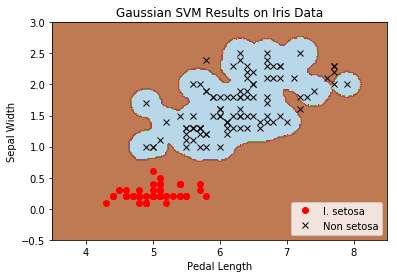

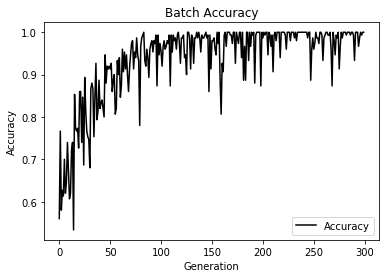

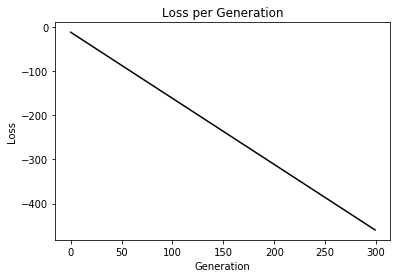

In [11]:
%matplotlib inline
# Plot points and grid
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='Non setosa')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

# Plot batch accuracy
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot loss over time
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

### Evaluate Test Points

We create a set of test points, and evaluate the class predictions

In [12]:
x_test_seq = np.array([4., 5., 6., 7.])
y_test_seq = np.array([0., 1., 2.])

x_test, y_test = np.meshgrid(x_test_seq,y_test_seq)
test_points = np.c_[x_test.ravel(), y_test.ravel()]

In [13]:
test_points

array([[ 4.,  0.],
       [ 5.,  0.],
       [ 6.,  0.],
       [ 7.,  0.],
       [ 4.,  1.],
       [ 5.,  1.],
       [ 6.,  1.],
       [ 7.,  1.],
       [ 4.,  2.],
       [ 5.,  2.],
       [ 6.,  2.],
       [ 7.,  2.]])

Now we can evaluate the predictions on our test points:

In [14]:
[test_predictions] = sess.run(prediction, feed_dict={x_data: rand_x,
                                                     y_target: rand_y,
                                                     prediction_grid: test_points})
test_predictions = test_predictions.reshape(x_test.shape)

In [15]:
test_predictions.ravel()

array([ 1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.], dtype=float32)

Format the test points together with the predictions:

In [16]:
for ix, point in enumerate(test_points):
    point_pred = test_predictions.ravel()[ix]
    print('Point {} is predicted to be in class {}'.format(point, point_pred))

Point [ 4.  0.] is predicted to be in class 1.0
Point [ 5.  0.] is predicted to be in class 1.0
Point [ 6.  0.] is predicted to be in class 1.0
Point [ 7.  0.] is predicted to be in class 1.0
Point [ 4.  1.] is predicted to be in class 1.0
Point [ 5.  1.] is predicted to be in class -1.0
Point [ 6.  1.] is predicted to be in class -1.0
Point [ 7.  1.] is predicted to be in class 1.0
Point [ 4.  2.] is predicted to be in class 1.0
Point [ 5.  2.] is predicted to be in class 1.0
Point [ 6.  2.] is predicted to be in class -1.0
Point [ 7.  2.] is predicted to be in class -1.0


In [17]:
import os
merged = tf.summary.merge_all(key='summaries')
if not os.path.exists('tensorboard_logs/'):
    os.makedirs('tensorboard_logs/')

my_writer = tf.summary.FileWriter('tensorboard_logs/', sess.graph)